# Paint-By-Number Generator with Pantone Colors

In this notebook, we will demonstrate how to create a paint-by-number lineart and map the closest Pantone colors to the image for a realistic representation.

In [397]:
import os
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from sklearn.cluster import KMeans, MiniBatchKMeans
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

## Match Colors to Closest Pantone Palette

This function identifies the closest acrylic or paint color from a given RGB value. The Pantone palette used is from [pycolorname](https://github.com/AbdealiLoKo/pycolorname), although you can create your own palette dictionary based on your available stock.

In [269]:
from pycolorname.pantone.pantonepaint import PantonePaint

def find_closest_pantone(r, g, b):
    tolerance=5
    palette = PantonePaint()
    input_color = [r, g, b]
    closest_pantone = None
    closest_distance = float('inf')
    
    for k, v in palette.items():
        distance = ((r - v[0]) ** 2 + (g - v[1]) ** 2 + (b - v[2]) ** 2) ** 0.5
        if distance <= tolerance and distance < closest_distance:
            closest_distance = distance
            closest_pantone = k
    
    if closest_pantone:
        return closest_pantone
    else:
        return "None"

In [263]:
def match_rgb_to_pantone_map(rgb_map):
    pantone_map = {}
    i = 0

    for k, v in rgb_map.items():
        r, g, b = v[0], v[1], v[2]
        pantone = find_closest_pantone(r, g, b)
        pantone_map.update(
            {i: {"pantone": pantone,
                 "rgb": [r, g, b]}
            })
        i += 1
    return pantone_map

def create_pantone_swatch(pantone_map, output_swatch_path):
    swatch_size, padding, font_size = 300, 20, 12
    swatch_count = len(pantone_map)
    swatch_width = swatch_count * (swatch_size + padding) + padding
    swatch_height = swatch_size + 5 * padding

    swatch = Image.new('RGB', (swatch_width, swatch_height), (255, 255, 255))

    draw = ImageDraw.Draw(swatch)

    font = ImageFont.truetype("fonts/arial.ttf", font_size)

    for i, values in pantone_map.items():
        rgb_color = values['rgb']
        x = i * (swatch_size + padding) + padding
        y = padding

        draw.rectangle((x, y, x+swatch_size, y+swatch_size), fill=tuple(rgb_color))

        pantone_str = values['pantone']
        draw.text((x, y+swatch_size+padding/2), pantone_str, font=font, fill=(0, 0, 0))

        color_str = str(rgb_color)
        draw.text((x, y+swatch_size+padding/2+font_size), color_str, font=font, fill=(0, 0, 0))
        swatch.save(output_swatch_path)
        
    return swatch

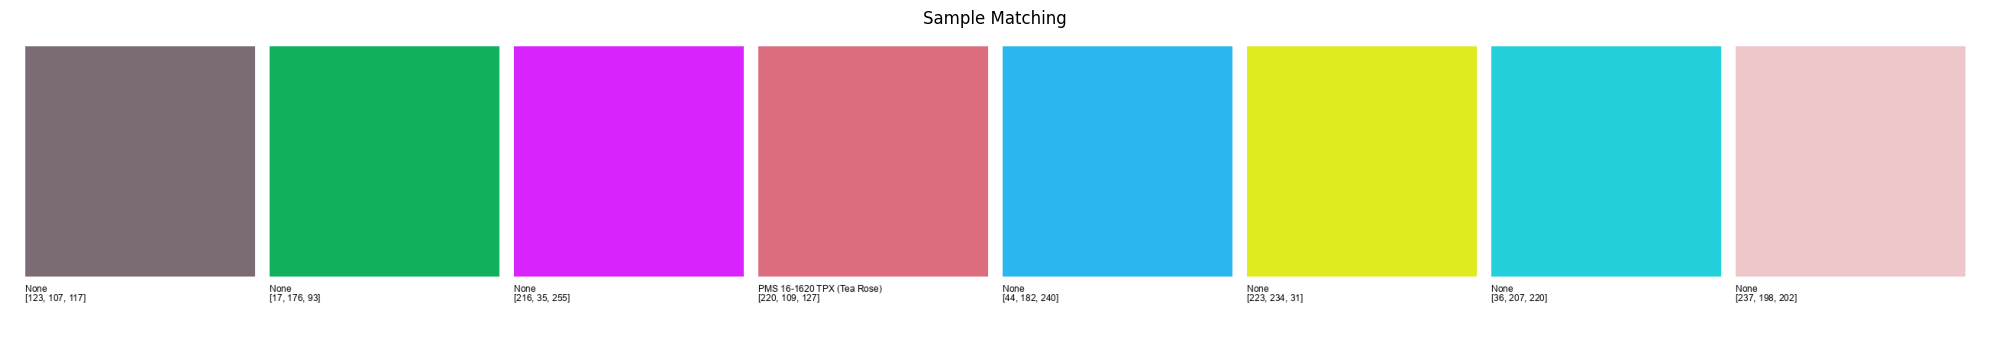

In [478]:
color = [randint(0, 255), randint(0, 255), randint(0, 255)]

rgb_map = {
    0: [randint(0, 255), randint(0, 255), randint(0, 255)],
    1: [randint(0, 255), randint(0, 255), randint(0, 255)],
    2: [randint(0, 255), randint(0, 255), randint(0, 255)],
    3: [randint(0, 255), randint(0, 255), randint(0, 255)],
    4: [randint(0, 255), randint(0, 255), randint(0, 255)],
    5: [randint(0, 255), randint(0, 255), randint(0, 255)],
    6: [randint(0, 255), randint(0, 255), randint(0, 255)],
    7: [randint(0, 255), randint(0, 255), randint(0, 255)]
}

pantone_map = match_rgb_to_pantone_map(rgb_map)
swatch = create_pantone_swatch(pantone_map, output_swatch_path="images/output/test.png")

fig = plt.figure(figsize=(20, 10))
plt.imshow(swatch)
plt.title("Sample Matching")
plt.axis("off")
plt.tight_layout()

## Color Quantization and Generate Lineart

This algorithm uses K-Means clustering to quantize the colors in an input image and create a color palette. It then creates a line art image based on the quantized colors with the corresponding color labels in the image, and a separate line art image with only the color labels.

In [441]:
def color_by_number_lineart(input_path, max_colors):
    output_path = 'images/output/'
    basename = os.path.splitext(os.path.basename(input_path))[0]
    
    image = cv2.imread(input_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    pixels = image.reshape(-1, 3)
    kmeans = KMeans(n_clusters=max_colors, n_init='auto')
    kmeans.fit(pixels)
    colors = kmeans.cluster_centers_.astype(int)
    
    # Color Quantization
    color_quantized = np.zeros_like(pixels)
    for i in range(max_colors):
        color_quantized[kmeans.labels_ == i] = colors[i]
    color_quantized = color_quantized.reshape(image.shape)
    
    output_quantized_path = os.path.join(output_path, f"{basename}_quantized.png")
    cv2.imwrite(output_quantized_path, cv2.cvtColor(color_quantized, cv2.COLOR_RGB2BGR))
    
    # Create swatch for color Quantization
    rgb_map = {}
    for i, val in enumerate(colors):
        rgb_color = [val[0], val[1], val[2]]
        rgb_map[i] = rgb_color
    
    pantone_map = match_rgb_to_pantone_map(rgb_map)
    output_swatch_path = os.path.join(output_path, f"{basename}_swatch.png")
    swatch = create_pantone_swatch(pantone_map, output_swatch_path)
    
    # Lineart with Numbers
    gray = cv2.cvtColor(color_quantized, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    lineart = cv2.bitwise_not(edges)
    labels_reshaped = kmeans.labels_.reshape(image.shape[:2])
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.3
    font_thickness = 1
    
    # Count number of occurrences of each color
    # This tells us how much of each color is needed
    color_counts = {}
    for i in range(max_colors):
        color_counts[i+1] = (labels_reshaped == i).sum()
    
    print(color_counts)

    for x in range(0, labels_reshaped.shape[0], 10):
        for y in range(0, labels_reshaped.shape[1], 10):
            color_label = labels_reshaped[x, y]
            cv2.putText(lineart, str(color_label + 1), (y, x), font, font_scale, (0, 0, 255), font_thickness, cv2.LINE_AA)

    output_lineart_path = os.path.join(output_path, f"{basename}_lineart.png")
    cv2.imwrite(output_lineart_path, lineart)

    # Lineart by Numbers
    lineart_numbers = np.full_like(image, 255)

    for x in range(0, labels_reshaped.shape[0], 10):
        for y in range(0, labels_reshaped.shape[1], 10):
            color_label = labels_reshaped[x, y]
            cv2.putText(lineart_numbers, str(color_label + 1), (y, x), font, font_scale, (0, 0, 0), font_thickness, cv2.LINE_AA)

    output_lineart_num_path = os.path.join(output_path, f"{basename}_lineart_numbers.png")
    cv2.imwrite(output_lineart_num_path, lineart_numbers)

    return image, swatch, color_quantized, lineart, lineart_numbers

### Color clusters by KMeans

KMeans may not be the best choice for capturing subtle color differences or for handling non-spherical clusters. Other clustering algorithms like DBSCAN, MeanShift, or Gaussian Mixture Models (GMM) may perform better for your specific use case.

{1: 143595, 2: 451729, 3: 99465, 4: 158888, 5: 122505, 6: 45070, 7: 160923, 8: 143003, 9: 20926, 10: 89671, 11: 128547, 12: 63790, 13: 17020, 14: 100148}


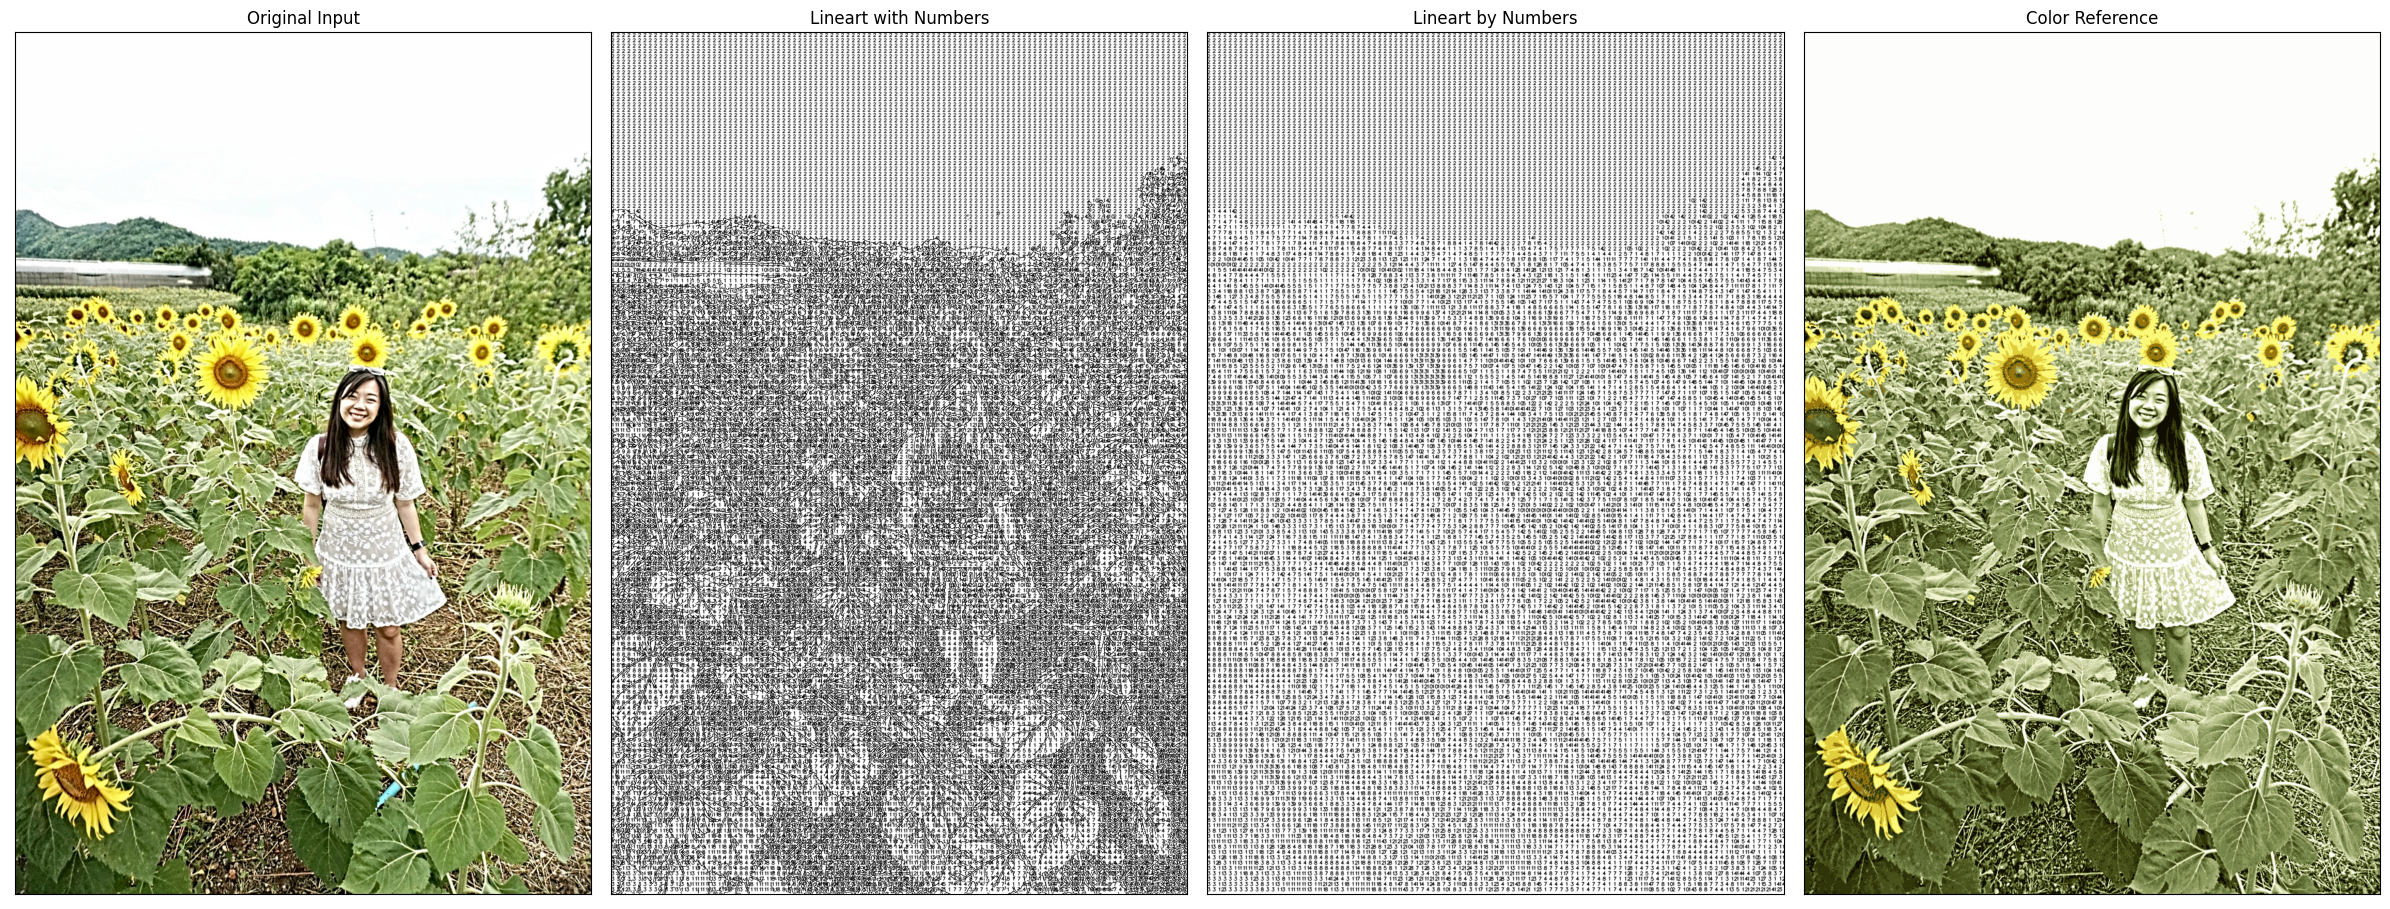

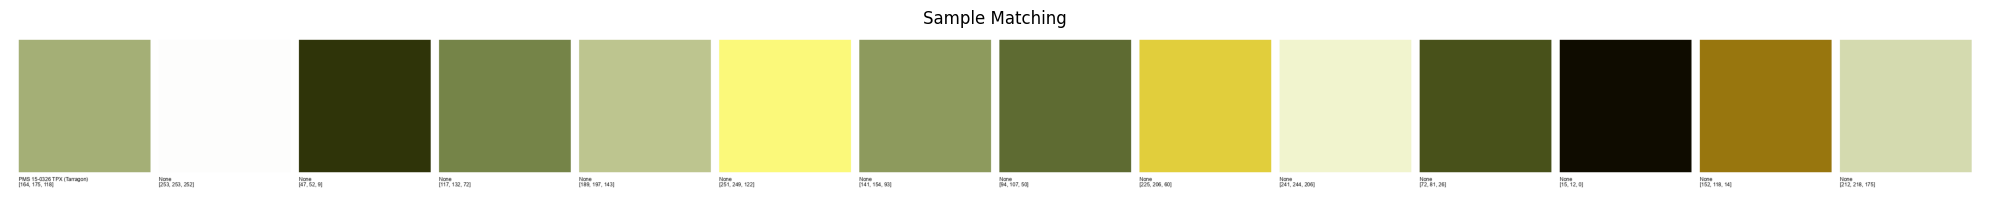

In [445]:
input_path = 'images/input/me_with_sunflowers_detailed.jpg'
image, swatch, color_quantized, lineart, lineart_numbers = color_by_number_lineart(input_path, max_colors=14)

fig, axs = plt.subplots(1, 4, figsize=(24, 10))

axs[0].imshow(image)
axs[0].set_title('Original Input')
axs[1].imshow(lineart, cmap='gray')
axs[1].set_title('Lineart with Numbers')
axs[2].imshow(lineart_numbers)
axs[2].set_title('Lineart by Numbers')
axs[3].imshow(color_quantized)
axs[3].set_title('Color Reference')

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

fig = plt.figure(figsize=(20, 10))
plt.imshow(swatch)
plt.title("Sample Matching")
plt.axis("off")
plt.tight_layout()